# Ha 2020 Model: Type 2 diabetes: one disease, many pathways

Ref: https://journals.physiology.org/doi/full/10.1152/ajpendo.00512.2019

Supplement: https://figshare.com/articles/journal_contribution/Mathematical_Model_of_Diabetes_Pathways/10792412

Source code: https://github.com/artielbm/artielbm.github.io/tree/master/Models/Pathways

In [1]:
import tellurium as te

In [2]:

# based on https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathways/pathway_matlab/pathway.m
r = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;
# y(1) = G, y(2) = I, y(3) = beta, y(4) = gam, y(5) = sigma, y(6) = si, y(7) = hepasi, y(8) = N5, y(9) = N6

# System parameters
Eg0=0.0118;  BV=7200; unit_con=0.0006944; k=0.4861;

# turning on or off the subsystems - meal, OGTT, IVGTT
meal=1; OGTT=0; IVGTT=0;
averG = 0; GT=1440;

# Define metabolic rate M and Insulin secretion rate ISR
Mmax=1; alpha_M=150; kM=2;
M := Mmax*G^kM/(alpha_M^kM + G^kM);

alpha_ISR=1.2; 
kISR=2;

ts=60; t_min=0.00069444;

# Define exocytosis
# Glucose Amplifying factor

GF_bar=4.4567; kGF=16; alpha_GF=260; shGF=-89; GF_b=1.7826;
GF := (0.1*IVGTT*GF_bar + (1-IVGTT)*GF_bar)*(G-shGF)^kGF/(alpha_GF^kGF + (G-shGF)^kGF) + GF_b;

ca_bar=2; kca=4; alpha_ca=0.62; ca_b=0.07; 
ci := ca_bar*(M + gam)^kca/(alpha_ca^kca + (M + gam)^kca) + ca_b;

k1=20; km1=100; r1=0.6; rm1=1; rm2=0.001;
r20=0.006; 


r30=1.205; rm3=0.0001; u1=2000; u2=3; u3=0.02; Kp2=2.3;

r2 := (0.1*IVGTT*r20 + (1-IVGTT)*r20)*ci/(ci + Kp2);


# Define Microdoman Ca2+
cmd_factor=150; cmd_b=0.0635; cik=4; cialpha=1;
cmd := cmd_factor*ci^cik/(cialpha^cik + ci^cik) + cmd_b;

r3 := sigma*GF*r30*ci/(ci + Kp2);

######
N1_C := km1/(3*k1*cmd + rm1);
N1_D := r1/(3*k1*cmd + rm1);

N2_E := 3*k1*cmd/(2*k1*cmd + km1);
N2_F := 2*km1/(2*k1*cmd + km1);

N3_L := 2*k1*cmd/(2*km1+k1*cmd);
N3_N := 3*km1/(2*km1+k1*cmd);

###### fast-slow analysis by considering N6 and N5 slow and all other fast.
CN4 := (k1*cmd/(3*km1 +u1));
CN3 := N3_L/(1-N3_N*CN4);
CN2 := N2_E/(1-N2_F*CN3);
CN1 := N1_D/(1-N1_C*CN2);


N1 := CN1*N5;
N2 := CN2*N1;
N3 := CN3*N2;
N4 := CN4*N3;
NF := u1*N4/u2;
NR := (u2/u3)*NF;

###### Build b dynamics and Define Proliferation rate P(ISR) and Apoptosis A(M)
         
ISR := ts*9*(u3*NR);
Pmax=4.55; kP=4; alpha_P=41.77;
P := Pmax*ISR^kP/(alpha_P^kP + ISR^kP);

Amax=3.11; alpha_A=0.44; kA=6; A_b=0.8;
A := Amax*M^kA/(alpha_A^kA + M^kA) + A_b;
tau_b = 10080000;

###### Build gam dynamics

Gs = 100;
G_bar=0.4; Gn=5; Gshft=0.2;
G_inf := G_bar/(1 + exp(-(G - Gs)/Gn)) - Gshft;
gam_inf := G_inf;
tau_g = 3081.6;

###### Build sigma dynamics
sigma_Gsh=35;
M_Gsh := Mmax*(G-sigma_Gsh)^kM/(alpha_M^kM + (G-sigma_Gsh)^kM);

ISRI_bar = 1.4; 
ISRI_s=0.1; ISRI_n=0.1; ISRI_k=1; sigma_b=0.01752;

sigma_ISRI := ISRI_bar/(1 + ISRI_k*exp(-(ISR - ISRI_s)/ISRI_n));

MI_bar=1; MI_k=0.2; MI_s=0.2; MI_n=0.02;

sigma_MI :=  1 - MI_bar/(1 + MI_k*exp(-(M_Gsh - MI_s)/MI_n));
sigma_inf := sigma_MI*sigma_ISRI + sigma_b; 

tau_sigma = 359856;

tau_si = 360000;
tar_si = 0.8
####################################

# meal Flux
period=360;
nspike=3;
rest=360;

active := nspike*period;
bperiod := active + rest; 

# mealbar is the average glucose intake in a meal
mealbar=11.055; mhill_k=4; mh_alpha=40; ita=0.3; mu=-0.015;
      
burstenv := ( piecewise(1, time % bperiod > 0, 0) -piecewise(1, time % bperiod > active, 0) );
mhill_fcn := (time % period)^mhill_k/(mh_alpha^mhill_k +(time % period)^mhill_k);
meal_rate :=  meal*(mealbar*(mhill_fcn)^ita*exp(mu*((time % period)))*burstenv);

####


######
# OGTT Flux ## unit [BW]=kg, [V_bar]=dl
BW = 75;
V_bar=1.569; OGTTbar=1; t1=15; 
t2=120; t3=240;
a1=588.5; a2=353.1; a3=0; 
t_g_0 := piecewise(1, time>0, 0);
t_g_t1 := piecewise(1, time>t1, 0);
t_g_t2 := piecewise(1, time>t2, 0);
t_g_t3 := piecewise(1, time>t3, 0);
OGTT_flux0 := (t_g_0 - t_g_t1)*time*a1/t1 + (t_g_t1-t_g_t2)*((time-t2)*(a2-a1)/(t2-t1)+a2) + (t_g_t2-t_g_t3)*(time-t3)*(a3-a2)/(t3-t2);
OGTT_rate := OGTT*OGTTbar*OGTT_flux0/(BW*V_bar);
        
# IVGTT Flux      

IVGTTbar=1471250; IVGTT_sh=0;
IVGTT_a=1; IVGTT_b=-10; 
IVGTT_sp=0;

IVGTT_rate :=  IVGTT*IVGTTbar*(time-IVGTT_sh)^IVGTT_a*exp(IVGTT_b*(time-IVGTT_sp))/(BW*V_bar);

# HGP model
HGP_no_si = 0;
hepa_bar=15.443; hepa_k=0.27; hepa_b=-3.54277; con_si=0.8;
hepa_max := hepa_bar/(hepa_k + si*(1-HGP_no_si) + con_si*HGP_no_si) + hepa_b;
      
alpha_max=6; alpha_k=0.4; alpha_b=-0.5;
alpha_HGP := alpha_max/(alpha_k + si*(1-HGP_no_si) + con_si*HGP_no_si) + alpha_b;

HGP_b=0.104166;  
HGP  := hepa_max/(alpha_HGP + I*hepasi) + HGP_b;

tar_hepasi = 1; tau_hepasi = 360000;

# ode system       

Gmean' = averG*G/GT;
G' = HGP + meal_rate + OGTT_rate + IVGTT_rate - (Eg0 + unit_con*si*I)*G;
I' = beta*ISR/BV  - k*I;  
beta' = (P - A)*beta/tau_b;
gam' = (gam_inf - gam)/tau_g;
sigma' = (sigma_inf - sigma)/tau_sigma;
si' = (-si + tar_si)/tau_si;

hepasi' =(-hepasi+ tar_hepasi)/tau_hepasi;

N5' = ts*(rm1*CN1*N5 - (r1 + rm2)*N5 + r2*N6);
N6' = ts*(r3 + rm2*N5 - (rm3 + r2)*N6);

# initial values
Gmean = 0
G = 78.59159991393697  
I = 5.637556083340107  
beta = 1533.917937647322 
gam = -0.07663502752199285  
sigma = 1
si = 0.8 
hepasi = 1 
N5 = 60.24283727598375 
N6 = 443.394497666619 
""")

In [3]:
r.resetToOrigin()
result = r.simulate(0, 1000, 1000)

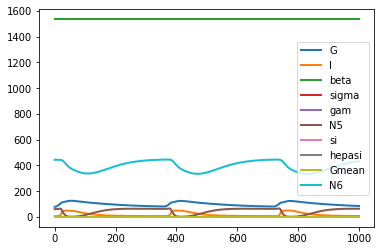

In [4]:
r.plot(result)

## Figure 1

longitudinal, time over several years